In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')

In [71]:
# LORENZ.DAT
data = pd.read_table('data/LORENZ.DAT', header=None)

# scaling
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

data = np.array(data).flatten()

In [72]:
# create d-dimensional data
t, d = 16, 3
lagged = []

for i in range(0, d+1):
    lagged.append(np.roll(data, -t*i)[:-t*d])
    
lagged = np.array(lagged).T
lagged.shape

(16336, 4)

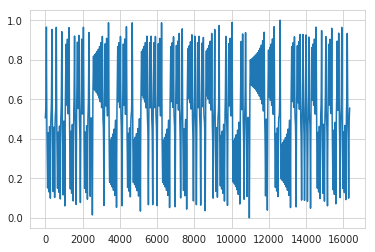

In [73]:
plt.plot(lagged[:, 0])

In [74]:
df = pd.DataFrame(lagged)
df.head()

,0,1,2,3
0,0.505204,0.529104,0.582915,0.804967
1,0.507508,0.530725,0.589690,0.827545
2,0.509557,0.532470,0.597134,0.850338
3,0.511395,0.534358,0.605311,0.872868
4,0.513057,0.536407,0.614286,0.894545


In [75]:
# split data
x = df[df.columns[0:-1]]
y = df[df.columns[-1]]

x = np.array(x)
y = np.array(y)


#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=None, shuffle=False)
X_train, X_test, y_train, y_test = x[0:500], x[500:1500], y[0:500], y[500:1500]

In [76]:
from sklearn.neural_network import MLPRegressor

In [77]:
clf = MLPRegressor(hidden_layer_sizes=(20, 20, 20), activation='relu',
                   batch_size=200, shuffle=False, solver='adam', random_state=42, verbose=False)
clf.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [78]:
pred = clf.predict(X_test)
print('R^2 method: ', clf.score(X_train, y_train))
print('R^2 method: ', clf.score(X_test, y_test))
print('R^2 import: ', r2_score(y_test, pred))
print('MSE: ', mean_squared_error(y_test, pred))

R^2 method:  0.4886116667250722
R^2 method:  0.47009697069458123
R^2 import:  0.47009697069458123
MSE:  0.02323555283251411


In [79]:
# calc error
# Ref: Nonlinear prediction of chaotic time series using support vector machines
# eq. (10)

error = 0
for i in range(len(pred)):
    error += (X_test[i] - pred[i])**2 / X_train.var()

print(error/len(pred))
print(np.log10(error/len(pred)))

[1.56765911 0.82946261 0.31961818]
[ 0.19525163 -0.08120318 -0.49536852]


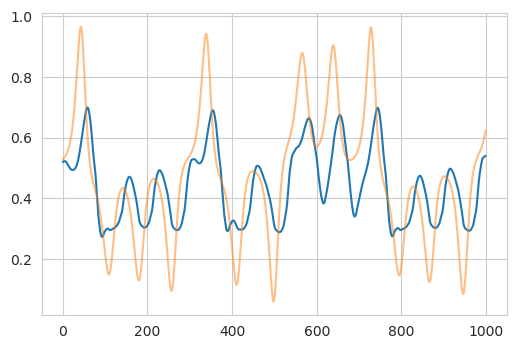

In [80]:
plt.figure(dpi=100)
plt.plot(pred)
plt.plot(y_test, alpha=0.5)

In [81]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [82]:
print(keras.wrappers.scikit_learn.__file__)

/home/yura/anaconda3/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py


In [83]:
def build_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(20, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(20, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(20, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Activation('linear'))
    
    adam = Adam() #epsilon=1e-08
    model.compile(loss='mse', optimizer=adam)
    #model.summary()
    
    return model

In [88]:
es_cb = EarlyStopping(monitor='binary_crossentropy', verbose=1, mode='auto')

estimator = KerasRegressor(build_fn=build_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train, shuffle=False) #, callbacks=[es_cb]

In [89]:
pred1 = estimator.predict(X_test)
print('R^2 method', estimator.score(X_train, y_train))
print('R^2 method', estimator.score(X_test, y_test))
print('R^2 import', r2_score(y_test, pred1))
print('MSE: ', mean_squared_error(y_test, pred1))

R^2 method -0.018501346427947284
R^2 method -0.01933252249378711
R^2 import 0.5782612236064866
MSE:  0.018492692206828882


In [90]:
# calc error
# Ref: Nonlinear prediction of chaotic time series using support vector machines
# eq. (10)

error = 0
for i in range(len(pred1)):
    error += (X_test[i] - pred1[i])**2 / X_train.var()

print(error/len(pred1))
print(np.log10(error/len(pred1)))

[1.73216983 1.06596504 0.21686148]
[ 0.23859047  0.02774296 -0.66381758]


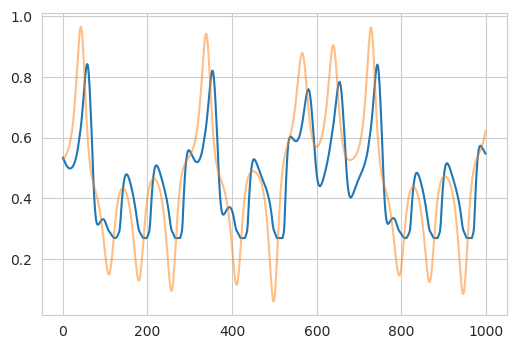

In [91]:
plt.figure(dpi=100)
plt.plot(pred1)
plt.plot(y_test, alpha=0.5)